In [20]:
# -*- coding: utf-8 -*-
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# ===============================
# 0) simplex vertices 
# ===============================
def simplex_vertices(K: int) -> torch.Tensor:
    w_list = []
    for j in range(1, K + 1):
        if j == 1:

            w_j = (1.0 / (K - 1) ** 0.5) * torch.ones(K - 1)
        else:

            term1 = -((1.0 + K ** 0.5) / ((K - 1) ** 1.5)) * torch.ones(K - 1)
            e = torch.zeros(K - 1)
            e[j - 2] = (K / (K - 1)) ** 0.5
            w_j = term1 + e
        w_list.append(w_j)
    return torch.stack(w_list)  # (K, K-1)

# ===============================
# 1) 시나리오별 delta 정의
# ===============================
def delta_scenario(X, scenario, K):
    """
    X: (n, p) with columns X1,...,Xp
    return: deltas (n, K=4)   each column k = δ_k(x)
    """
    
    n, p = X.shape
    d = np.zeros((n, K))
    x1, x2, x3, x4 = X[:,0], X[:,1], X[:,2], X[:,3]
    # 여분 변수도 쓸 수 있음
    if p >= 6:
        x5, x6 = X[:,4], X[:,5]
    else:
        x5 = np.zeros(n); x6 = np.zeros(n)

    if scenario == 1:
        # Linear (논문 식)
        d[:,0] = 1 + x1 + x2 + x3 + x4           
        d[:,1] = 1 + x1 - x2 - x3 + x4            
        d[:,2] = 1 + x1 - x2 + x3 - x4           
        d[:,3] = 1 - x1 - x2 + x3 + x4         

    elif scenario == 2:
        # Tree type (indicator)
        d[:,0] = 3.0 * ((x1 <= 0.5).astype(float) * ((x2 > -0.6).astype(float) - 1.0))                      
        d[:,1] = ((x3 <= 1.0).astype(float)) * (2.0*(x4 <= -0.3).astype(float) - 1.0)                     
        d[:,2] = (4.0*(x5 <= 0.0).astype(float) - 2.0)                                           
        d[:,3] = (4.0*(x6 <= 0.0).astype(float) - 2.0)                                                            

    elif scenario == 3:
        # Poly type (두 변수 +, 두 변수 - : 자연스러운 순환 패턴)
        d[:,0] = 0.2 + x1**2 + x2**2 - x3**2 - x4**2      
        d[:,1] = 0.2 + x2**2 + x3**2 - x1**2 - x4**2   
        d[:,2] = 0.2 + x3**2 + x4**2 - x1**2 - x2**2      
        d[:,3] = 0.2 + x1**2 + x4**2 - x2**2 - x3**2   
    else:
        raise ValueError("scenario must be 1, 2, or 3")

    return d  # (n,4)

# ===============================
# 2) 데이터 생성
# ===============================

def mu_default(X):
    """
    논문 기본설정: μ(x) = 1 + X1 + X2  (X는 (n,p), X1=X[:,0], X2=X[:,1])
    나머지 시나리오에서도 mu가 동일하게 적용되는지 모르겠음. appendix에서 알려준대놓고 안 알려줌;;
    """
    return 1.0 + X[:, 0] + X[:, 1]

def mu_poly(X):
    x1, x2 = X[:,0], X[:,1]
    return 1.0 + 0.6*x1 + 0.6*x2 + 0.4*(x1**2) - 0.3*(x2**2) + 0.2*(x1*x2)


def simulate_data(n=2000, p=10, K=4, scenario=1, seed=0,
                  main_effect=mu_default, sigma_eps=1.0, uniform_low=-1.0, uniform_high=1.0):
    """
    논문 5.1과 동일한 형태:
      - X_ij ~ Uniform[-1,1]
      - ε_i ~ N(0, 1) (sigma_eps로 조정 가능)
      - R = μ(X) + δ_A(X) + ε
    반환: X, A, R, true_opt  (true_opt은 argmax_k δ_k(X))
    """
    rng = np.random.default_rng(seed)

    # X ~ Unif[-1,1]
    X = rng.uniform(uniform_low, uniform_high, size=(n, p))

    # δ_k(x)들 (n,K)
    deltas = delta_scenario(X, scenario, K=K) 

    mu = main_effect(X)                     

    # 치료법은 무작위배정
    A = rng.integers(0, K, size=n)

    eps = rng.normal(0.0, sigma_eps, size=n)
    R = mu + deltas[np.arange(n), A] + eps

    # 최적 치료 (Ground truth): main effect 제외
    true_opt = np.argmax(deltas, axis=1)

    return X, A, R, true_opt

# ===============================
# 3) 선형 AD-learning (원 논문식)
# ===============================
def ad_linear(X, A, R, K=4, alpha=1.0):
    n, p = X.shape
    V = simplex_vertices(K).numpy()                   # (K, K-1)
    Y = np.zeros((n, K-1))
    for i in range(n):
        Y[i,:] = K * R[i] * V[A[i]]                   # 반응: K * R * w_A

    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(X, Y)

    def predict(X_new):
        f = model.predict(X_new)                      # (m, K-1)
        scores = f @ V.T                              # (m, K)
        return scores.argmax(axis=1)
    return model, V, predict

# ===============================
# 4) 신경망 AD-learning 
# ===============================
class ADNet(nn.Module):
    def __init__(self, p, out_dim, hidden=[128,128]):
        super().__init__()
        layers = []
        d = p
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU()]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

def ad_nn(X, A, R, K=4, epochs=60, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n, p = X.shape
    V = simplex_vertices(K).to(device)                # (K, K-1)

    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    A_t = torch.tensor(A, dtype=torch.long, device=device)
    R_t = torch.tensor(R, dtype=torch.float32, device=device)

    model = ADNet(p, K-1).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train(); opt.zero_grad()
        f = model(X_t)                                # (n, K-1)
        wA = V[A_t]                                   # (n, K-1)
        pred = (f*wA).sum(1)                          # <f, w_A>
        loss = ((R_t - pred)**2).mean()
        loss.backward(); opt.step()
        if (ep+1) % 10 == 0:
            print(f"[NN] epoch {ep+1}/{epochs} loss={loss.item():.4f}")

    def predict(X_new):
        X_new_t = torch.tensor(X_new, dtype=torch.float32, device=device)
        with torch.no_grad():
            f = model(X_new_t)                        # (m, K-1)
            scores = f @ V.T                          # (m, K)
            return scores.argmax(1).cpu().numpy()
    return model, V.cpu().numpy(), predict


# ===============================
# 5) 평가 (Error rate & IPW Value)
# ===============================
def evaluate_policy(predict_fn, X, A, R, K, true_opt=None):
    pred = predict_fn(X)
    error_rate = None if true_opt is None else np.mean(pred != true_opt)
    # IPW value (균등배정 → P(A|X)=1/K)
    value = np.mean(R * (pred == A) * K)
    return error_rate, value




In [21]:
def run_once(scenario, seed, K=4, p=10, n=2000, nn_epochs=60, nn_lr=1e-3):
    # 재현성
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # 데이터 생성 & 분할
    X, A, R, opt = simulate_data(n=n, p=p, K=K, scenario=scenario, seed=seed)
    X_tr, X_te, A_tr, A_te, R_tr, R_te, opt_tr, opt_te = \
        train_test_split(X, A, R, opt, test_size=0.3, random_state=seed+999)

    # Linear AD
    _, _, lin_pred = ad_linear(X_tr, A_tr, R_tr, K=K, alpha=1.0)
    err_lin, val_lin = evaluate_policy(lin_pred, X_te, A_te, R_te, K, true_opt=opt_te)

    # NN AD
    _, _, nn_pred = ad_nn(X_tr, A_tr, R_tr, K=K, epochs=nn_epochs, lr=nn_lr)
    err_nn, val_nn = evaluate_policy(nn_pred, X_te, A_te, R_te, K, true_opt=opt_te)

    return (err_lin, val_lin, err_nn, val_nn)

def mean_var(xs):
    xs = np.asarray(xs, dtype=float)
    mean = xs.mean()
    var = xs.var(ddof=1) if xs.size > 1 else 0.0
    return mean, var

def run_experiments(n_trials=20, scenarios=(1,2,3), base_seed=12345, K=4, p=10, n=2000,
                    nn_epochs=60, nn_lr=1e-3):
    results = {}  # scenario -> dict of lists
    for sc in scenarios:
        lin_errs, lin_vals, nn_errs, nn_vals = [], [], [], []
        for t in range(n_trials):
            seed = base_seed + 1000*sc + t  # 시나리오별로 다른 시드 스트림
            e_lin, v_lin, e_nn, v_nn = run_once(sc, seed, K=K, p=p, n=n,
                                                nn_epochs=nn_epochs, nn_lr=nn_lr)
            lin_errs.append(e_lin); lin_vals.append(v_lin)
            nn_errs.append(e_nn);  nn_vals.append(v_nn)

        
        lin_err_mean, lin_err_var = mean_var(lin_errs)
        lin_val_mean, lin_val_var = mean_var(lin_vals)
        nn_err_mean,  nn_err_var  = mean_var(nn_errs)
        nn_val_mean,  nn_val_var  = mean_var(nn_vals)

        results[sc] = {
            "lin_err": lin_errs, "lin_val": lin_vals,
            "nn_err": nn_errs,   "nn_val": nn_vals,
            "summary": {
                "Linear": {"Error_mean": lin_err_mean, "Error_var": lin_err_var,
                           "Value_mean": lin_val_mean, "Value_var": lin_val_var},
                "NN":     {"Error_mean": nn_err_mean,  "Error_var": nn_err_var,
                           "Value_mean": nn_val_mean,  "Value_var": nn_val_var},
            }
        }

        
        print("\n" + "="*12 + f" Scenario {sc} ({n_trials} runs) " + "="*12)
        print(f"[Linear-AD]  Error mean={lin_err_mean:.4f}, var={lin_err_var:.6f} | "
              f"Value mean={lin_val_mean:.4f}, var={lin_val_var:.6f}")
        print(f"[NN-AD]      Error mean={nn_err_mean:.4f}, var={nn_err_var:.6f} | "
              f"Value mean={nn_val_mean:.4f}, var={nn_val_var:.6f}")

    return results

In [22]:
# 스크립트로 실행 시
if __name__ == "__main__":
    _ = run_experiments(
        n_trials=20,
        scenarios=(1,2,3),
        base_seed=12345,
        K=7, p=10, n=800,
        nn_epochs=60, nn_lr=1e-3
    )

[NN] epoch 10/60 loss=4.8385
[NN] epoch 20/60 loss=4.4549
[NN] epoch 30/60 loss=4.1032
[NN] epoch 40/60 loss=3.7122
[NN] epoch 50/60 loss=3.3597
[NN] epoch 60/60 loss=3.0563
[NN] epoch 10/60 loss=4.6813
[NN] epoch 20/60 loss=4.3766
[NN] epoch 30/60 loss=4.1076
[NN] epoch 40/60 loss=3.7993
[NN] epoch 50/60 loss=3.4915
[NN] epoch 60/60 loss=3.2016
[NN] epoch 10/60 loss=4.9224
[NN] epoch 20/60 loss=4.5766
[NN] epoch 30/60 loss=4.2588
[NN] epoch 40/60 loss=3.9042
[NN] epoch 50/60 loss=3.5835
[NN] epoch 60/60 loss=3.3006
[NN] epoch 10/60 loss=4.8184
[NN] epoch 20/60 loss=4.4834
[NN] epoch 30/60 loss=4.1283
[NN] epoch 40/60 loss=3.7371
[NN] epoch 50/60 loss=3.3809
[NN] epoch 60/60 loss=3.0856
[NN] epoch 10/60 loss=4.7564
[NN] epoch 20/60 loss=4.3786
[NN] epoch 30/60 loss=4.0659
[NN] epoch 40/60 loss=3.7597
[NN] epoch 50/60 loss=3.4818
[NN] epoch 60/60 loss=3.2346
[NN] epoch 10/60 loss=4.8220
[NN] epoch 20/60 loss=4.4792
[NN] epoch 30/60 loss=4.1031
[NN] epoch 40/60 loss=3.7017
[NN] epoch 50/

## 베이스라인 벡터(KRW) 손실함수 vs 신경망 벡터(KRW) 손실함수

이게 정석이긴 한데, 결과는 좀 잘 안나옴.

In [109]:


def ad_nn_vector_target(X, A, R, K=4, epochs=60, lr=1e-3, hidden=[128,128]):
    """
    AD-NN (vector regression version, target = K*R*w_A)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n, p = X.shape
    V = torch.tensor(simplex_vertices(K), dtype=torch.float32, device=device)  # (K, K-1)

    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    A_t = torch.tensor(A, dtype=torch.long, device=device)
    R_t = torch.tensor(R, dtype=torch.float32, device=device)

    # 타깃: Y = K * R * w_A
    Y_t = (K * R_t[:, None]) * V[A_t]   # (n, K-1)

    model = ADNet(p=p, out_dim=K-1, hidden=hidden).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train(); opt.zero_grad()
        f = model(X_t)                 # (n, K-1)
        loss = (((Y_t - f) ** 2)/(K-1)).mean() # 벡터 회귀
        loss.backward(); opt.step()
        if (ep+1) % 10 == 0:
            print(f"[NN-vec] epoch {ep+1}/{epochs} loss={loss.item():.4f}")

    def predict(X_new):
        X_new_t = torch.tensor(X_new, dtype=torch.float32, device=device)
        with torch.no_grad():
            f = model(X_new_t)          # (m, K-1)
            scores = f @ V.T            # (m, K)  Ridge와 동일
            return scores.argmax(1).cpu().numpy()

    return model, V.cpu().numpy(), predict

In [63]:
# ===============================
# 6) 시나리오별 실행 데모
# ===============================
if __name__ == "__main__":
    K, p, n =4, 10, 2000
    for scenario in [1, 2, 3]:
        print("\n" + "="*12, f"Scenario {scenario}", "="*12)
        X, A, R, opt = simulate_data(K=K, n=n, p=p, scenario=scenario, seed=42)
        X_tr, X_te, A_tr, A_te, R_tr, R_te, opt_tr, opt_te = \
            train_test_split(X, A, R, opt, test_size=0.3, random_state=123)

        # Linear AD
        lin_model, V_lin, lin_pred = ad_linear(X_tr, A_tr, R_tr, K=K, alpha=1.0)
        err_lin, val_lin = evaluate_policy(lin_pred, X_te, A_te, R_te, K, true_opt=opt_te)

        # NN AD
        nn_model, V_nn, nn_pred = ad_nn_vector_target(X_tr, A_tr, R_tr, K=K, epochs=60, lr=1e-3)
        err_nn, val_nn = evaluate_policy(nn_pred, X_te, A_te, R_te, K, true_opt=opt_te)

        print(f"Linear-AD : Error={err_lin:.3f}  |  IPW-Value={val_lin:.3f}")
        print(f"NN-AD     : Error={err_nn:.3f}  |  IPW-Value={val_nn:.3f}")


============ Scenario 1 ============
[NN-vec] epoch 10/60 loss=11.5962
[NN-vec] epoch 20/60 loss=11.4315
[NN-vec] epoch 30/60 loss=11.2396
[NN-vec] epoch 40/60 loss=11.0833
[NN-vec] epoch 50/60 loss=10.9879
[NN-vec] epoch 60/60 loss=10.9070
Linear-AD : Error=0.210  |  IPW-Value=3.309
NN-AD     : Error=0.307  |  IPW-Value=3.203

============ Scenario 2 ============
[NN-vec] epoch 10/60 loss=8.5146
[NN-vec] epoch 20/60 loss=8.3324
[NN-vec] epoch 30/60 loss=8.0953
[NN-vec] epoch 40/60 loss=7.8605
[NN-vec] epoch 50/60 loss=7.7204


/var/folders/cm/ns0p72dd663b344v05p7gz080000gn/T/ipykernel_79817/654617832.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  V = torch.tensor(simplex_vertices(K), dtype=torch.float32, device=device)  # (K, K-1)
/var/folders/cm/ns0p72dd663b344v05p7gz080000gn/T/ipykernel_79817/654617832.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  V = torch.tensor(simplex_vertices(K), dtype=torch.float32, device=device)  # (K, K-1)


[NN-vec] epoch 60/60 loss=7.6389
Linear-AD : Error=0.278  |  IPW-Value=2.459
NN-AD     : Error=0.285  |  IPW-Value=2.555

============ Scenario 3 ============
[NN-vec] epoch 10/60 loss=5.5696
[NN-vec] epoch 20/60 loss=5.5306
[NN-vec] epoch 30/60 loss=5.4832
[NN-vec] epoch 40/60 loss=5.4251
[NN-vec] epoch 50/60 loss=5.3532
[NN-vec] epoch 60/60 loss=5.2660
Linear-AD : Error=0.755  |  IPW-Value=1.221
NN-AD     : Error=0.693  |  IPW-Value=1.357


/var/folders/cm/ns0p72dd663b344v05p7gz080000gn/T/ipykernel_79817/654617832.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  V = torch.tensor(simplex_vertices(K), dtype=torch.float32, device=device)  # (K, K-1)


## 논문 베이스라인도 스칼라 손실함수 vs 신경망도 스칼라 손실함수

베이스라인 벡터 손실함수 vs 신경망 스칼라 손실함수와 거의 동일한 경과.
수학적으로 동치라고 하는데 괜찮은건지 잘 모르겠음.

In [7]:
import numpy as np
from sklearn.linear_model import Ridge

def ad_linear_scalar(X, A, R, K=4, alpha=1.0):
    """
    AD-learning (scalar target version).
    X: (n, p)
    A: (n,) ∈ {0,...,K-1}
    R: (n,)
    """
    n, p = X.shape
    V = simplex_vertices(K).numpy()   # (K, K-1)

    # target = R_i
    y = R

    # feature map: phi(x,a) = kron(x, w_a)
    # 즉, x와 w_a의 크로네커 곱을 feature로 사용
    X_feat = np.zeros((n, p * (K - 1)))
    for i in range(n):
        w = V[A[i]]                    # (K-1,)
        # Kronecker product: x ⊗ w
        X_feat[i, :] = np.kron(X[i], w)

    # Ridge 회귀: f는 (p*(K-1)) 차원 파라미터로 학습됨
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(X_feat, y)

    def predict(X_new):
        m = X_new.shape[0]
        scores = np.zeros((m, K))
        for k in range(K):
            w = V[k]                    # (K-1,)
            # weight 벡터를 (p,(K-1)) 행렬로 reshape
            W = model.coef_.reshape(p, K-1)
            fX = X_new @ W              # (m, K-1)
            scores[:, k] = fX @ w       # <f(X), w_k>
        return scores.argmax(axis=1)

    return model, V, predict

In [45]:
# ===============================
# 6) 시나리오별 실행 데모
# ===============================
if __name__ == "__main__":
    K, p, n = 5, 10, 800
    for scenario in [1, 2, 3]:
        print("\n" + "="*12, f"Scenario {scenario}", "="*12)
        X, A, R, opt = simulate_data(n=n, p=p, scenario=scenario, seed=42)
        X_tr, X_te, A_tr, A_te, R_tr, R_te, opt_tr, opt_te = \
            train_test_split(X, A, R, opt, test_size=0.3, random_state=123)

        # Linear AD
        lin_model, V_lin, lin_pred = ad_linear_scalar(X_tr, A_tr, R_tr, K=K, alpha=1.0)
        err_lin, val_lin = evaluate_policy(lin_pred, X_te, A_te, R_te, K, true_opt=opt_te)

        # NN AD
        nn_model, V_nn, nn_pred = ad_nn(X_tr, A_tr, R_tr, K=K, epochs=60, lr=1e-3)
        err_nn, val_nn = evaluate_policy(nn_pred, X_te, A_te, R_te, K, true_opt=opt_te)

        print(f"Linear-AD : Error={err_lin:.3f}  |  IPW-Value={val_lin:.3f}")
        print(f"NN-AD     : Error={err_nn:.3f}  |  IPW-Value={val_nn:.3f}")


============ Scenario 1 ============
[NN] epoch 10/60 loss=5.9688
[NN] epoch 20/60 loss=4.6991
[NN] epoch 30/60 loss=3.1325
[NN] epoch 40/60 loss=1.9910
[NN] epoch 50/60 loss=1.5484
[NN] epoch 60/60 loss=1.1909
Linear-AD : Error=0.542  |  IPW-Value=2.710
NN-AD     : Error=0.254  |  IPW-Value=3.789

============ Scenario 2 ============
[NN] epoch 10/60 loss=4.5168
[NN] epoch 20/60 loss=3.8654
[NN] epoch 30/60 loss=3.0995
[NN] epoch 40/60 loss=2.4207
[NN] epoch 50/60 loss=1.9438
[NN] epoch 60/60 loss=1.5955
Linear-AD : Error=0.562  |  IPW-Value=2.003
NN-AD     : Error=0.237  |  IPW-Value=2.703

============ Scenario 3 ============
[NN] epoch 10/60 loss=2.8026
[NN] epoch 20/60 loss=2.2433
[NN] epoch 30/60 loss=1.6896
[NN] epoch 40/60 loss=1.4043
[NN] epoch 50/60 loss=1.2139
[NN] epoch 60/60 loss=1.0577
Linear-AD : Error=0.863  |  IPW-Value=1.333
NN-AD     : Error=0.729  |  IPW-Value=1.761


## 레이어 개수 그리드 서치

In [26]:
# -*- coding: utf-8 -*-
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from collections import defaultdict

# ----------------------------------------------------
# 0) 신경망 정의 (은닉층 수/너비를 파라미터로)
# ----------------------------------------------------
class ADNet(nn.Module):
    def __init__(self, input_dim, out_dim, hidden_width=128, num_layers=2):
        """
        input_dim: p
        out_dim: K-1 (simplex 차원)
        hidden_width: 64 또는 128
        num_layers: 1, 2, 3 (은닉층 수)
        """
        super().__init__()
        layers = []
        d = input_dim
        for _ in range(num_layers):
            layers += [nn.Linear(d, hidden_width), nn.ReLU()]
            d = hidden_width
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)  # (batch, K-1)

# ----------------------------------------------------
# 1) AD-NN 학습 루틴 (균등 설계 → 가중치 상수 → 평범한 MSE)
# ----------------------------------------------------
def train_ad_nn(X, A, R, K=4, hidden_width=128, num_layers=2, epochs=60, lr=1e-3, verbose=False, device=None):
    """
    균등 배정 가정 (pi = 1/K): 목적식 상수배 → 가중치 생략 OK
    X: (n, p) numpy
    A: (n,) numpy, {0,...,K-1}
    R: (n,) numpy
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    n, p = X.shape
    V = torch.tensor(generate_simplex_coding(K), dtype=torch.float32, device=device)  # (K, K-1)

    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    A_t = torch.tensor(A, dtype=torch.long, device=device)
    R_t = torch.tensor(R, dtype=torch.float32, device=device)

    model = ADNet(input_dim=p, out_dim=K-1, hidden_width=hidden_width, num_layers=num_layers).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train()
        opt.zero_grad()
        f = model(X_t)                 # (n, K-1)
        wA = V[A_t]                    # (n, K-1)
        pred = (f * wA).sum(1)         # <f(X), w_A>
        loss = ((R_t - pred) ** 2).mean()
        loss.backward()
        opt.step()
        if verbose and (ep + 1) % 10 == 0:
            print(f"[NN] epoch {ep+1}/{epochs}  loss={loss.item():.4f}")

    # 예측 함수
    def predict(X_new):
        X_new_t = torch.tensor(X_new, dtype=torch.float32, device=device)
        with torch.no_grad():
            f = model(X_new_t)         # (m, K-1)
            scores = f @ V.T           # (m, K)
            return scores.argmax(1).cpu().numpy()

    return model, predict

# ----------------------------------------------------
# 2) 평가 지표 (Error rate & IPW Value)
# ----------------------------------------------------
def evaluate_policy(predict_fn, X, A, R, K, true_opt=None):
    pred = predict_fn(X)
    error_rate = None if true_opt is None else np.mean(pred != true_opt)
    # 균등 무작위 배정 → P(A|X)=1/K → IPW value = E[ R * I(d(X)=A) * K ]
    value = np.mean(R * (pred == A) * K)
    return error_rate, value

# ----------------------------------------------------
# 3) 그리드 서치 실행기
# ----------------------------------------------------
def grid_search_nn(
    scenario=1,                  # delta 시나리오 (1=linear, 2=tree, 3=poly 같은 식으로 당신 코드와 맞춰주세요)
    main_effect=None,                  # main effect 함수 (없으면 μ(x)=1+X1+X2 가정하는 simulate_data에 기본값으로)
    n=3000, p=10, K=4,
    test_size=0.3, seed=42,
    epochs=60, lr=1e-3,
    widths=(64, 128),
    layers=(1, 2, 3),
    verbose=False
):
    """
    delta_scenario, simulate_data, generate_simplex_coding 이 이미 정의되어 있다고 가정.
    simulate_data는 다음 형태:
      X~Unif[-1,1], R = μ(X) + δ_A(X) + ε, true_opt = argmax_k δ_k(X)
    """
    # ----- 데이터 생성 -----
    X, A, R, true_opt = simulate_data(n=n, p=p, K=K, scenario=scenario, seed=seed,
                                      main_effect=mu_default,
                                      sigma_eps=1.0)

    Xtr, Xte, Atr, Ate, Rtr, Rte, opttr, optte = train_test_split(
        X, A, R, true_opt, test_size=test_size, random_state=123
    )

    results = []
    best = {"err": np.inf, "val": -np.inf, "cfg_err": None, "cfg_val": None}

    for w in widths:
        for L in layers:
            # ----- 학습 -----
            _, predict_fn = train_ad_nn(
                Xtr, Atr, Rtr, K=K,
                hidden_width=w, num_layers=L,
                epochs=epochs, lr=lr, verbose=verbose
            )
            # ----- 평가 -----
            err, val = evaluate_policy(predict_fn, Xte, Ate, Rte, K, true_opt=optte)
            results.append({"width": w, "layers": L, "error": err, "value": val})
            if verbose:
                print(f"[scen{scenario}] width={w}, layers={L}  -->  error={err:.3f}, value={val:.3f}")

            # best by error (작을수록 좋음)
            if err is not None and err < best["err"]:
                best["err"] = err
                best["cfg_err"] = (w, L)
            # best by value (클수록 좋음)
            if val > best["val"]:
                best["val"] = val
                best["cfg_val"] = (w, L)

    # 정렬된 요약 출력용
    results_sorted_err = sorted(results, key=lambda d: d["error"])
    results_sorted_val = sorted(results, key=lambda d: -d["value"])

    return {
        "all": results,
        "rank_by_error": results_sorted_err,
        "rank_by_value": results_sorted_val,
        "best_error": {"metric": best["err"], "config": {"width": best["cfg_err"][0], "layers": best["cfg_err"][1]}},
        "best_value": {"metric": best["val"], "config": {"width": best["cfg_val"][0], "layers": best["cfg_val"][1]}},
    }

# ----------------------------------------------------
# 4) 실행 예시
# ----------------------------------------------------
if __name__ == "__main__":
    # 예: scenario=1 (linear δ), μ 기본(1+X1+X2), n=3000
    out = grid_search_nn(
        scenario=1, n=3000, p=10, K=4,
        widths=(64, 128), layers=(1, 2, 3),
        epochs=60, lr=1e-3, verbose=True
    )

    print("\n=== 정렬 (Error 오름차순) ===")
    for r in out["rank_by_error"]:
        print(f"layers={r['layers']}, width={r['width']} | error={r['error']:.3f}, value={r['value']:.3f}")

    print("\n=== 정렬 (Value 내림차순) ===")
    for r in out["rank_by_value"]:
        print(f"layers={r['layers']}, width={r['width']} | error={r['error']:.3f}, value={r['value']:.3f}")

    print("\nBest by Error:", out["best_error"])
    print("Best by Value:", out["best_value"])


[NN] epoch 10/60  loss=6.9073
[NN] epoch 20/60  loss=6.8074
[NN] epoch 30/60  loss=6.7103
[NN] epoch 40/60  loss=6.6122
[NN] epoch 50/60  loss=6.5112
[NN] epoch 60/60  loss=6.4075
[scen1] width=64, layers=1  -->  error=0.311, value=3.050
[NN] epoch 10/60  loss=6.8949
[NN] epoch 20/60  loss=6.7457
[NN] epoch 30/60  loss=6.5473
[NN] epoch 40/60  loss=6.3098
[NN] epoch 50/60  loss=6.0726
[NN] epoch 60/60  loss=5.8880
[scen1] width=64, layers=2  -->  error=0.178, value=3.028
[NN] epoch 10/60  loss=6.9384
[NN] epoch 20/60  loss=6.8010
[NN] epoch 30/60  loss=6.5463
[NN] epoch 40/60  loss=6.1954
[NN] epoch 50/60  loss=5.9036
[NN] epoch 60/60  loss=5.7497
[scen1] width=64, layers=3  -->  error=0.199, value=3.048
[NN] epoch 10/60  loss=6.8722
[NN] epoch 20/60  loss=6.7159
[NN] epoch 30/60  loss=6.5685
[NN] epoch 40/60  loss=6.4235
[NN] epoch 50/60  loss=6.2807
[NN] epoch 60/60  loss=6.1444
[scen1] width=128, layers=1  -->  error=0.223, value=3.069
[NN] epoch 10/60  loss=6.7403
[NN] epoch 20/60 

## 새롭게 짠 코드

In [2]:
import numpy as np

def delta_scenario(X, scenario: int, K: int,
                       smooth: bool = False,
                       temp: float = 0.25,    
                       amp: float = 1.0):       
    """
    """
    n, p = X.shape
    d = np.zeros((n, K))
    xs = [X[:, j % p] for j in range(max(p, 6))]
    x1,x2,x3,x4,x5,x6 = xs[:6]

    def _sigmoid(z): return 1.0 / (1.0 + np.exp(-z))
    def _phi(u): return np.tanh(u)

    # ---------- Scenario 1 : Linear ----------
    if scenario == 1:

        if K >= 1: d[:,0] = 1 + x1 + x2 + x3 + x4
        if K >= 2: d[:,1] = 1 + x1 - x2 - x3 + x4
        if K >= 3: d[:,2] = 1 + x1 - x2 + x3 - x4
        if K >= 4: d[:,3] = 1 - x1 - x2 + x3 + x4


    # ---------- Scenario 2 : Tree ----------
    elif scenario == 2:
        if not smooth:
            if K >= 1: d[:,0] = 3.0 * ((x1 <= 0.5).astype(float) * ((x2 > -0.6).astype(float) - 1.0))
            if K >= 2: d[:,1] = ((x3 <= 1.0).astype(float)) * (2.0*(x4 <= -0.3).astype(float) - 1.0)
            if K >= 3: d[:,2] = (4.0*(x5 <= 0.0).astype(float) - 2.0)
            if K >= 4: d[:,3] = (4.0*(x6 <= 0.0).astype(float) - 2.0)
        else:
            s1 = _sigmoid((0.5 - x1)/temp)   
            s2 = _sigmoid((x2 + 0.6)/temp)    
            s3 = _sigmoid((1.0 - x3)/temp) 
            s4 = _sigmoid((-0.3 - x4)/temp)   
            s5 = _sigmoid((0.0 - x5)/temp)    
            s6 = _sigmoid((0.0 - x6)/temp)  
            if K >= 1: d[:,0] = amp * 3.0 * s1 * (2.0*s2 - 1.0)
            if K >= 2: d[:,1] = amp * s3 * (2.0*s4 - 1.0)
            if K >= 3: d[:,2] = amp * (4.0*s5 - 2.0)
            if K >= 4: d[:,3] = amp * (4.0*s6 - 2.0)

    # ---------- Scenario 3 : Polynomial ----------
    elif scenario == 3:
        if not smooth:
            if K >= 1: d[:,0] = 0.2 + x1**2 + x2**2 - x3**2 - x4**2
            if K >= 2: d[:,1] = 0.2 + x2**2 + x3**2 - x1**2 - x4**2
            if K >= 3: d[:,2] = 0.2 + x3**2 + x4**2 - x1**2 - x2**2
            if K >= 4: d[:,3] = 0.2 + x1**2 + x4**2 - x2**2 - x3**2
        else:
            # 교차항 + 합성 비선형
            c12 = _phi(0.8*x1*x2); c23 = _phi(0.8*x2*x3)
            c34 = _phi(0.8*x3*x4); c14 = _phi(0.8*x1*x4)
            h1  = _phi(0.7*x1 + 0.5*x2 - 0.4*x3 + 0.3*x4)
            h2  = _phi(-0.6*x1 + 0.7*x2 + 0.5*x3 - 0.4*x4)
            if K >= 1: d[:,0] = amp*(0.2 + x1**2 + x2**2 - x3**2 - x4**2 + 0.6*c12 + 0.4*h1)
            if K >= 2: d[:,1] = amp*(0.2 + x2**2 + x3**2 - x1**2 - x4**2 + 0.6*c23 + 0.4*h2)
            if K >= 3: d[:,2] = amp*(0.2 + x3**2 + x4**2 - x1**2 - x2**2 + 0.6*c34 + 0.4*h1)
            if K >= 4: d[:,3] = amp*(0.2 + x1**2 + x4**2 - x2**2 - x3**2 + 0.6*c14 + 0.4*h2)
    else:
        raise ValueError("scenario must be 1, 2, or 3")

    if K <= 4:
        return d

    def lin_arm(j):
        P = [j % p, (j+1) % p]
        M = [(j+2) % p, (j+3) % p]

        return 1.0 + X[:,P[0]] + X[:,P[1]] - X[:,M[0]] - X[:,M[1]]


    def poly_arm(j):
        P = [j % p, (j+1) % p]; M = [(j+2) % p, (j+3) % p]
        if not smooth:
            return 0.2 + X[:,P[0]]**2 + X[:,P[1]]**2 - X[:,M[0]]**2 - X[:,M[1]]**2
        cP = _phi(0.8*X[:,P[0]]*X[:,P[1]])
        h  = _phi(0.7*X[:,P[0]] - 0.6*X[:,P[1]] + 0.4*X[:,M[0]] - 0.3*X[:,M[1]])
        base = 0.2 + X[:,P[0]]**2 + X[:,P[1]]**2 - X[:,M[0]]**2 - X[:,M[1]]**2
        return amp*(base + 0.6*cP + 0.4*h)

    def tree_tmpl(t, j):
        jp = j % p; jn1 = (j+1) % p
        if not smooth:
            if t == 0:
                return 3.0 * ((X[:,jp] <= 0.5).astype(float) * ((X[:,jn1] > -0.6).astype(float) - 1.0))
            elif t == 1:
                return ((X[:,jp] <= 1.0).astype(float)) * (2.0*(X[:,jn1] <= -0.3).astype(float) - 1.0)
            else:
                return (4.0*(X[:,jp] <= 0.0).astype(float) - 2.0)
        if t == 0:
            sA = _sigmoid((0.5 - X[:,jp])/temp); sB = _sigmoid((X[:,jn1] + 0.6)/temp)
            return amp * (3.0 * sA * (2.0*sB - 1.0))
        elif t == 1:
            sA = _sigmoid((1.0 - X[:,jp])/temp); sB = _sigmoid((-0.3 - X[:,jn1])/temp)
            return amp * (sA * (2.0*sB - 1.0))
        else:
            sA = _sigmoid((0.0 - X[:,jp])/temp)
            return amp * (4.0*sA - 2.0)

    start_j = 0
    for k in range(4, K):
        j = (start_j + 2*(k-4))
        if scenario == 1:
            d[:,k] = lin_arm(j)
        elif scenario == 2:
            t = (k-4) % 4
            d[:,k] = tree_tmpl(t, j)
        elif scenario == 3:
            d[:,k] = poly_arm(j)

    return d


In [3]:


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# ===============================
# 0) simplex vertices 
# ===============================
def simplex_vertices(K: int) -> torch.Tensor:
    w_list = []
    for j in range(1, K + 1):
        if j == 1:

            w_j = (1.0 / (K - 1) ** 0.5) * torch.ones(K - 1)
        else:

            term1 = -((1.0 + K ** 0.5) / ((K - 1) ** 1.5)) * torch.ones(K - 1)
            e = torch.zeros(K - 1)
            e[j - 2] = (K / (K - 1)) ** 0.5
            w_j = term1 + e
        w_list.append(w_j)
    return torch.stack(w_list)  # (K, K-1)


def delta_scenario_past(X, scenario: int, K: int):
    """
    원 논문의 시나리오 1~3을 구현해놓음.
    """
    n, p = X.shape
    d = np.zeros((n, K))

    x = [X[:, j % p] for j in range(max(p, 6))]  
    x1,x2,x3,x4,x5,x6 = x[0],x[1],x[2],x[3],x[4],x[5]

    if scenario == 1:  # linear
        if K >= 1: d[:,0] = 1 + x1 + x2 + x3 + x4
        if K >= 2: d[:,1] = 1 + x1 - x2 - x3 + x4
        if K >= 3: d[:,2] = 1 + x1 - x2 + x3 - x4
        if K >= 4: d[:,3] = 1 - x1 - x2 + x3 + x4

    elif scenario == 2:  # tree 
        if K >= 1: d[:,0] = 3.0 * ((x1 <= 0.5).astype(float) * ((x2 > -0.6).astype(float) - 1.0))
        if K >= 2: d[:,1] = ((x3 <= 1.0).astype(float)) * (2.0*(x4 <= -0.3).astype(float) - 1.0)
        if K >= 3: d[:,2] = (4.0*(x5 <= 0.0).astype(float) - 2.0)
        if K >= 4: d[:,3] = (4.0*(x6 <= 0.0).astype(float) - 2.0)

    elif scenario == 3:  # polynomial
        if K >= 1: d[:,0] = 0.2 + x1**2 + x2**2 - x3**2 - x4**2
        if K >= 2: d[:,1] = 0.2 + x2**2 + x3**2 - x1**2 - x4**2
        if K >= 3: d[:,2] = 0.2 + x3**2 + x4**2 - x1**2 - x2**2
        if K >= 4: d[:,3] = 0.2 + x1**2 + x4**2 - x2**2 - x3**2
    else:
        raise ValueError("scenario must be 1, 2, or 3")

    if K <= 4:
        return d


    def lin_arm(j):
        P = [j % p, (j+1) % p]
        M = [(j+2) % p, (j+3) % p]
        return 1.0 + X[:,P[0]] + X[:,P[1]] - X[:,M[0]] - X[:,M[1]]

    def poly_arm(j):
        P = [j % p, (j+1) % p]
        M = [(j+2) % p, (j+3) % p]
        return 0.2 + X[:,P[0]]**2 + X[:,P[1]]**2 - X[:,M[0]]**2 - X[:,M[1]]**2


    def tree_tmpl(t, j):
        jp = j % p; jn1 = (j+1) % p
        if t == 0:
            return 3.0 * ((X[:,jp] <= 0.5).astype(float) * ((X[:,jn1] > -0.6).astype(float) - 1.0))
        elif t == 1:
            return ((X[:,jp] <= 1.0).astype(float)) * (2.0*(X[:,jn1] <= -0.3).astype(float) - 1.0)
        elif t == 2:
            return (4.0*(X[:,jp] <= 0.0).astype(float) - 2.0)
        else:
            return (4.0*(X[:,jp] <= 0.0).astype(float) - 2.0)

    # k=5부터 채우기
    start_j = 0  
    for k in range(4, K):
        j = (start_j + 2*(k-4))  
        if scenario == 1:
            d[:,k] = lin_arm(j)
        elif scenario == 2:
            t = (k-4) % 4       
            d[:,k] = tree_tmpl(t, j)
        elif scenario == 3:
            d[:,k] = poly_arm(j)

    return d




# ===============================
# 2) 데이터 생성
# ===============================

def mu_default(X):
    """
    논문 기본설정: μ(x) = 1 + X1 + X2  (X는 (n,p), X1=X[:,0], X2=X[:,1])
    나머지 시나리오에서도 mu가 동일하게 적용되는지 모르겠음. appendix에서 알려준대놓고 안 알려줌;;
    """
    return 1.0 + X[:, 0] + X[:, 1]

# def mu_poly(X):
#     x1, x2 = X[:,0], X[:,1]
#     return 1.0 + 0.6*x1 + 0.6*x2 + 0.4*(x1**2) - 0.3*(x2**2) + 0.2*(x1*x2)


def simulate_data(K, n=2000, p=10, scenario=1, seed=0,
                  main_effect=mu_default, sigma_eps=1.0,
                  uniform_low=-1.0, uniform_high=1.0, smooth=False):

    rng = np.random.default_rng(seed)

    # X ~ Unif[-1, 1]
    X = rng.uniform(uniform_low, uniform_high, size=(n, p))

    deltas = delta_scenario(X, scenario, K, smooth)
    mu = main_effect(X)

    # A를 가능한 균등하게 분배
    base = n // K
    counts = np.full(K, base, dtype=int)
    counts[: (n % K)] += 1       
    A = np.repeat(np.arange(K), counts)
    rng.shuffle(A)                


    eps = rng.normal(0.0, sigma_eps, size=n)
    R = mu + deltas[np.arange(n), A] + eps

    # 최적 치료 (Ground truth): main effect 제외
    true_opt = np.argmax(deltas, axis=1)

    return X, A, R, true_opt

# ===============================
# 3) 선형 AD-learning
# Ridge로 간단하게 구현한 것.
# ===============================
def ad_linear(X, A, R, K, alpha=1.0):
    n, p = X.shape
    V = simplex_vertices(K).numpy()           
    Y = np.zeros((n, K-1))
    for i in range(n):
        Y[i,:] = K * R[i] * V[A[i]]                  

    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(X, Y)

    def predict(X_new):
        f = model.predict(X_new)               
        scores = f @ V.T                            
        return scores.argmax(axis=1)
    return model, V, predict

# ===============================
# 4) 신경망 AD-learning 
# ===============================
class ADNet(nn.Module):
    def __init__(self, p, out_dim, hidden=[128,128]):
        super().__init__()
        layers = []
        d = p
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU()]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

def ad_nn(X, A, R, K, epochs=50, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n, p = X.shape
    V = simplex_vertices(K).to(device)     

    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    A_t = torch.tensor(A, dtype=torch.long, device=device)
    R_t = torch.tensor(R, dtype=torch.float32, device=device)

    model = ADNet(p, K-1).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train(); opt.zero_grad()
        f = model(X_t)                        
        wA = V[A_t]                            
        pred = (f*wA).sum(1)                       
        loss = ((R_t - pred)**2).mean()

        loss.backward(); opt.step()
        if (ep+1) % 10 == 0:
            print(f"[NN] epoch {ep+1}/{epochs} loss={loss.item():.4f}")

    def predict(X_new):
        X_new_t = torch.tensor(X_new, dtype=torch.float32, device=device)
        with torch.no_grad():
            f = model(X_new_t)                  
            scores = f @ V.T                 
            return scores.argmax(1).cpu().numpy()
    return model, V.cpu().numpy(), predict



# ===============================
# 5) 평가 (Error rate & IPW Value)
# ===============================
def evaluate_policy(predict_fn, X, A, R, K, true_opt=None):
    pred = predict_fn(X)
    error_rate = None if true_opt is None else np.mean(pred != true_opt)
    value = np.mean(R * (pred == A) * K)
    return error_rate, value



In [4]:
import numpy as np


def _group_soft_threshold_rowwise(B, tau):
    """
    group sparsity
    """
    B_new = B.copy()
    norms = np.linalg.norm(B_new, axis=1)             # (p,)
    scale = np.maximum(0.0, 1.0 - tau / (norms + 1e-12))
    B_new = scale[:, None] * B_new
    return B_new

def ad_linear_group(
    X, A, R, K,
    lam=0.05,            
    step=1e-2,      
    max_iter=1000,
    tol=1e-6,
    pi=None,
    alpha=1.0
):
    n, p = X.shape
    V = simplex_vertices(K).numpy() 
    if pi is None:
        pi = np.full(n, 1.0 / K, dtype=float)

    Y = np.zeros((n, K-1), dtype=float)
    for i in range(n):
        Y[i, :] = (R[i] / pi[i]) * V[A[i]]

    # 초기값
    B = np.zeros((p, K-1), dtype=float)

    for it in range(max_iter):
        XB = X @ B
        # 그래디언트
        grad = (2.0 / n) * (X.T @ (XB - Y))
        # gradient step
        B_next = B - step * grad
        # group sparsity
        B_next = _group_soft_threshold_rowwise(B_next, tau=step * lam)

        # 수렴 체크
        denom = max(1.0, np.linalg.norm(B, ord='fro'))
        if np.linalg.norm(B_next - B, ord='fro') <= tol * denom:
            B = B_next
            break
        B = B_next


    def predict(X_new):
        F = X_new @ B            
        scores = F @ V.T       
        return scores.argmax(axis=1)


    model = {"B": B}
    return model, V, predict


### x 표준화 추가 버전

In [74]:
import numpy as np

def _group_soft_threshold_rowwise(B, tau):
    """행(특징) 단위 L2 소프트임계: b_j <- (1 - tau/||b_j||)_+ * b_j"""
    norms = np.linalg.norm(B, axis=1)              # (p,)
    scale = np.maximum(0.0, 1.0 - tau / (norms + 1e-12))
    return scale[:, None] * B




def ad_linear_group_standardized(
    X, A, R, K,
    lam=1.0,          # λ * ||B||_{2,1}
    step=1e-3,        # 고정 step size
    max_iter=2000,
    tol=1e-6,
    pi=None,          # propensity P(A|X); None이면 균등(=1/K)
    V=None,
    alpha=1.0
):
    """
    센터링 + 표준화 버전.
    목적:  min_B (1/n)∑ ||Y_i - B^T ((x_i - μ)/σ)||_2^2 + lam * ||B||_{2,1}
      - Y_i = (R_i / π_i) w_{A_i}; 균등배정이면 π_i=1/K → Y_i = K R_i w_{A_i}
    예측:  argmax_k  ((B^T ((x - μ)/σ)) · w_k)
    """
    n, p = X.shape
    if V is None:
        V = simplex_vertices(K).numpy()  # (K, K-1)
    if pi is None:
        pi = np.full(n, 1.0 / K, dtype=float)

    # Target Y ∈ R^{n×(K-1)}
    Y = np.zeros((n, K-1), dtype=float)
    for i in range(n):
        Y[i, :] = (R[i] / pi[i]) * V[A[i]]

    # -------- 표준화 --------
    X_mean = X.mean(axis=0, keepdims=True)       # (1, p)
    X_std = X.std(axis=0, keepdims=True) + 1e-12 # (1, p)
    Xs = (X - X_mean) / X_std                    # (n, p)
    # ------------------------

    # 초기값
    B = np.zeros((p, K-1), dtype=float)

    # ISTA (prox-gradient)
    for _ in range(max_iter):
        XB = Xs @ B                                   # (n, K-1)
        grad = (2.0 / n) * (Xs.T @ (XB - Y))          # (p, K-1)
        B_next = B - step * grad
        B_next = _group_soft_threshold_rowwise(B_next, tau=step * lam)

        if np.linalg.norm(B_next - B, ord='fro') <= tol * max(1.0, np.linalg.norm(B, ord='fro')):
            B = B_next
            break
        B = B_next

    def predict(X_new):
        Xs_new = (X_new - X_mean) / X_std
        F = Xs_new @ B
        scores = F @ V.T
        return scores.argmax(axis=1)


    model = {"B": B, "X_mean": X_mean, "X_std": X_std}
    return model, V, predict

In [5]:
import numpy as np

def run_experiments(K, p=10, n=2000, n_test=10000, scenario_list=[1,2,3],
                    n_repeats=20, epochs=60, lr=1e-3, alpha=1.0, smooth=False):
    """
    학습: 크기 n의 학습 데이터 전체 사용
    평가: 크기 n_test의 독립 테스트 데이터로만 평가
    """
    results = {}

    for scenario in scenario_list:
        err_lin_list, val_lin_list = [], []
        err_nn_list, val_nn_list = [], []

        for rep in range(n_repeats):
            print(f"[Scenario {scenario}] Repeat {rep+1}/{n_repeats}")

            # 1) Train set (size = n)
            train_seed = 42 + rep
            X_tr, A_tr, R_tr, opt_tr = simulate_data(
                K=K, n=n, p=p, scenario=scenario, seed=train_seed, smooth=smooth
            )


            # 2) Fit models on train set
            # Linear AD
            lin_model, V_lin, lin_pred = ad_linear_group(X_tr, A_tr, R_tr, K=K, alpha=alpha)

            # NN AD
            nn_model, V_nn, nn_pred = ad_nn(X_tr, A_tr, R_tr, K=K, epochs=epochs, lr=lr)


            # 3) Independent Test set (size = n_test)
            test_seed = 1_000_000 + train_seed
            X_te, A_te, R_te, opt_te = simulate_data(
                K=K, n=n_test, p=p, scenario=scenario, seed=test_seed, smooth=smooth
            )

            # 4) Evaluate on test only
            err_lin, val_lin = evaluate_policy(lin_pred, X_te, A_te, R_te, K, true_opt=opt_te)
            err_nn,  val_nn  = evaluate_policy(nn_pred,  X_te, A_te, R_te, K, true_opt=opt_te)

            err_lin_list.append(err_lin); val_lin_list.append(val_lin)
            err_nn_list.append(err_nn);   val_nn_list.append(val_nn)

        results[scenario] = {
            "Linear": {
                "Error_mean": float(np.mean(err_lin_list)),
                "Error_var":  float(np.var(err_lin_list, ddof=1)),
                "Value_mean": float(np.mean(val_lin_list)),
                "Value_var":  float(np.var(val_lin_list, ddof=1)),
            },
            "NN": {
                "Error_mean": float(np.mean(err_nn_list)),
                "Error_var":  float(np.var(err_nn_list, ddof=1)),
                "Value_mean": float(np.mean(val_nn_list)),
                "Value_var":  float(np.var(val_nn_list, ddof=1)),
            }
        }
    
    return results


In [5]:
# 코드 실행 (스크립트용)

if __name__ == "__main__":
    results = run_experiments(K=4, p=10, n=2000, n_test=10000, n_repeats=20,
                               epochs=50, lr=1e-3, smooth=True)
    for scen, res in results.items():
        print("\n" + "="*10, f"Scenario {scen}", "="*10)
        for model_name, stats in res.items():
            print(f"{model_name:7s} | "
                  f"Error mean={stats['Error_mean']:.3f}, var={stats['Error_var']:.4f} | "
                  f"Value mean={stats['Value_mean']:.3f}, var={stats['Value_var']:.4f}")

[NN] epoch 10/50 loss=6.6621
[NN] epoch 20/50 loss=6.3100
[NN] epoch 30/50 loss=5.9645
[NN] epoch 40/50 loss=5.7794
[NN] epoch 50/50 loss=5.6779
[NN] epoch 10/50 loss=6.5740
[NN] epoch 20/50 loss=6.2032
[NN] epoch 30/50 loss=5.8408
[NN] epoch 40/50 loss=5.6350
[NN] epoch 50/50 loss=5.5351
[NN] epoch 10/50 loss=6.6033
[NN] epoch 20/50 loss=6.2389
[NN] epoch 30/50 loss=5.8843
[NN] epoch 40/50 loss=5.6797
[NN] epoch 50/50 loss=5.5554
[NN] epoch 10/50 loss=6.7905
[NN] epoch 20/50 loss=6.4154
[NN] epoch 30/50 loss=6.0476
[NN] epoch 40/50 loss=5.8654
[NN] epoch 50/50 loss=5.7681
[NN] epoch 10/50 loss=6.7626
[NN] epoch 20/50 loss=6.3904
[NN] epoch 30/50 loss=6.0177
[NN] epoch 40/50 loss=5.7854
[NN] epoch 50/50 loss=5.6585
[NN] epoch 10/50 loss=6.7750
[NN] epoch 20/50 loss=6.3989
[NN] epoch 30/50 loss=6.0003
[NN] epoch 40/50 loss=5.7534
[NN] epoch 50/50 loss=5.6547
[NN] epoch 10/50 loss=6.6756
[NN] epoch 20/50 loss=6.3127
[NN] epoch 30/50 loss=5.9676
[NN] epoch 40/50 loss=5.7791
[NN] epoch 50/

## Survival

In [19]:
import numpy as np


def simulate_data_surv(
    K,
    n=2000,
    p=10,
    scenario=1,
    seed=0,
    main_effect=mu_default,  # μ(x)
    uniform_low=-1.0,
    uniform_high=1.0,
    theta_cens=3.0,
    smooth: bool = False,    
):
    """
    생존형 outcome (time-to-event)을 delta 기반 구조로 생성.
    lambda_i = mu(x_i) + delta_{A_i}(x_i)
    R_i ~ Exp(rate = exp(lambda_i))

    Delta = 1 이면 event 발생, 0 이면 censoring
    """


    rng = np.random.default_rng(seed)

    # ------------------------------------------
    # 1) Covariates X
    # ------------------------------------------
    X = rng.uniform(uniform_low, uniform_high, size=(n, p))

    # ------------------------------------------
    # 2) Delta matrix: (n, K)
    # ------------------------------------------
    deltas = delta_scenario(X, scenario, K, smooth)
    # ------------------------------------------
    # 3) Main effect μ(x)
    # ------------------------------------------
    mu = main_effect(X)     # (n,)
    mu_col = mu.reshape(-1, 1)

    # ------------------------------------------
    # 4) True optimal arm = argmax survival time
    #    생존시간 ~ 1 / exp(lambda) => lambda가 가장 작은 arm이 최적
    # ------------------------------------------
    lambda_mat = mu_col + deltas     # (n,K)
    true_opt = np.argmin(lambda_mat, axis=1)

    # ------------------------------------------
    # 5) 실제 치료 A: 균등 분배
    # ------------------------------------------
    base = n // K
    counts = np.full(K, base, dtype=int)
    counts[:(n % K)] += 1
    A = np.repeat(np.arange(K), counts)
    rng.shuffle(A)

    # ------------------------------------------
    # 6) 개별 λ_i 및 rate = exp(λ_i)
    # ------------------------------------------
    lambdas = lambda_mat[np.arange(n), A]
    rates = np.exp(lambdas)

    # ------------------------------------------
    # 7) Event time R_true ~ Exp(rate)
    # ------------------------------------------
    R_true = rng.exponential(scale=1.0/rates)

    # ------------------------------------------
    # 8) Censoring times
    # ------------------------------------------
    C = rng.exponential(scale=theta_cens, size=n)

    # ------------------------------------------
    # 9) Observed times
    # ------------------------------------------
    T = np.minimum(R_true, C)
    Delta = (R_true <= C).astype(int)

    return X, A, T, Delta, true_opt


In [7]:
import numpy as np


def ad_linear_group_survival(
    X, A, T, Delta, K,
    lam=0.05,
    step=1e-2,
    max_iter=1000,
    tol=1e-6,
    pi=None,
):
    """
    AD-learning linear model for survival outcome.
    - X: (n, p) covariates
    - A: (n,) treatment index in {0,...,K-1}
    - T: (n,) observed time
    - Delta: (n,) event indicator (1=event, 0=censored)
    - K: number of treatments

    Objective:
        Cox partial negative log-likelihood with IPW + group L2 penalty on rows of B.

    Hazard score:
        F  = X @ B        # (n, K-1)
        V  = simplex_vertices(K).numpy()    # (K, K-1)
        scores = F @ V.T  # (n, K)
        eta_i  = scores[i, A[i]]

    Weights:
        w_i = Delta_i / (n * pi_i)

    Returns
    -------
    model: {"B": B}
    V    : simplex vertices (K, K-1)
    predict: function(X_new) -> argmin_k hazard score
    """
    n, p = X.shape
    V = simplex_vertices(K).numpy()  # (K, K-1)

    if pi is None:
        pi = np.full(n, 1.0 / K, dtype=float)
    pi = np.asarray(pi, dtype=float)

    # row-wise group soft-threshold
    def _group_soft_threshold_rowwise(B, tau):
        B_new = B.copy()
        norms = np.linalg.norm(B_new, axis=1)  # (p,)
        scale = np.maximum(0.0, 1.0 - tau / (norms + 1e-12))
        B_new = scale[:, None] * B_new
        return B_new

    # Cox gradient helper: dL/deta (shape: (n,))
    def _cox_grad_eta(eta, T, Delta, pi):
        """
        eta: (n,) linear predictor for actually received treatment
        T:   (n,) observed time
        Delta: (n,) event indicator
        pi:  (n,) propensity
        Implements gradient of:
            L = - (1/n) sum_{i:Delta_i=1} (1/pi_i) [ eta_i - log sum_{j:T_j>=T_i} exp(eta_j) ]
        """
        n = len(eta)
        # weights w_i = Delta_i / (n * pi_i)
        w = Delta.astype(float) / (pi * n)

        # sort by time ascending
        order = np.argsort(T)
        T_s = T[order]
        eta_s = eta[order]
        w_s = w[order]

        exp_eta = np.exp(eta_s)

        # cumulative risk set sums: R_i = sum_{j: T_j >= T_i} exp(eta_j)
        # with T sorted ascending, risk set for i is j >= i
        cum_exp_rev = np.cumsum(exp_eta[::-1])[::-1]  # (n,)

        grad_s = -w_s.copy()  # start from -w_k term

        # add risk-set contributions; only for events (w_s>0)
        for i in range(n):
            if w_s[i] == 0.0:
                continue
            denom = cum_exp_rev[i]  # R_i
            contrib = w_s[i] * exp_eta[i:] / denom  # shape (n-i,)
            grad_s[i:] += contrib

        # unsort back
        grad = np.zeros_like(grad_s)
        grad[order] = grad_s
        return grad  # shape (n,)

    # initialize B
    B = np.zeros((p, K-1), dtype=float)

    for it in range(max_iter):
        # forward
        F = X @ B                 # (n, K-1)
        scores = F @ V.T          # (n, K)
        eta = scores[np.arange(n), A]  # (n,)

        # gradient wrt eta from Cox partial likelihood
        grad_eta = _cox_grad_eta(eta, T, Delta, pi)   # (n,)

        # backprop to scores: only column A gets grad_eta
        grad_scores = np.zeros_like(scores)
        grad_scores[np.arange(n), A] = grad_eta       # (n, K)

        # backprop to F: scores = F @ V.T  => dL/dF = grad_scores @ V
        grad_F = grad_scores @ V                      # (n, K-1)

        # backprop to B: F = X @ B  => dL/dB = X^T @ grad_F
        grad_B = X.T @ grad_F                         # (p, K-1)

        # gradient step + group l2 proximal
        B_next = B - step * grad_B
        B_next = _group_soft_threshold_rowwise(B_next, tau=step * lam)

        # convergence check
        denom = max(1.0, np.linalg.norm(B, ord='fro'))
        if np.linalg.norm(B_next - B, ord='fro') <= tol * denom:
            B = B_next
            break
        B = B_next

    def predict(X_new):
        """
        Predict optimal treatment index for new X_new.
        For survival outcome, hazard가 가장 작은 arm 선택 → argmin.
        """
        F_new = X_new @ B            # (m, K-1)
        scores_new = F_new @ V.T     # (m, K)
        return scores_new.argmin(axis=1)

    model = {"B": B}
    return model, V, predict


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class ADNet(nn.Module):
    def __init__(self, p, out_dim, hidden=[128,128]):
        super().__init__()
        layers = []
        d = p
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU()]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


def ad_nn_survival(X, A, T, Delta, K, epochs=50, lr=1e-3, pi=None):
    """
    AD-learning 신경망 (생존 outcome, Cox partial likelihood)

    Parameters
    ----------
    X      : (n, p) numpy array, covariates
    A      : (n,) numpy array, treatment index (0,...,K-1)
    T      : (n,) numpy array, observed time
    Delta  : (n,) numpy array, event indicator (1=event, 0=censor)
    K      : number of treatments
    pi     : (n,) treatment assignment prob; None이면 1/K로 가정

    Returns
    -------
    model  : trained ADNet
    V_np   : simplex vertices (K, K-1) as numpy array
    predict: function(X_new) -> argmin_k (hazard score)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = np.asarray(X, dtype=np.float32)
    A = np.asarray(A, dtype=np.int64)
    T = np.asarray(T, dtype=np.float32)
    Delta = np.asarray(Delta, dtype=np.float32)

    n, p = X.shape

    # simplex vertices
    V = simplex_vertices(K).to(device)  # (K, K-1)

    # tensors
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    A_t = torch.tensor(A, dtype=torch.long, device=device)
    T_t = torch.tensor(T, dtype=torch.float32, device=device)
    Delta_t = torch.tensor(Delta, dtype=torch.float32, device=device)

    if pi is None:
        pi = np.full(n, 1.0 / K, dtype=np.float32)
    pi_t = torch.tensor(pi, dtype=torch.float32, device=device)

    model = ADNet(p, K-1).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    def cox_ipw_loss(eta, T_t, Delta_t, pi_t):
        """
        eta : (n,) log-hazard for actually received treatment
        """
        n = eta.shape[0]
        # 정렬 (시간 오름차순)
        order = torch.argsort(T_t)
        T_s = T_t[order]
        eta_s = eta[order]
        Delta_s = Delta_t[order]
        pi_s = pi_t[order]

        exp_eta = torch.exp(eta_s)
        # risk set 합: R_i = sum_{j: T_j >= T_i} exp(eta_j)
        cum_exp_rev = torch.cumsum(exp_eta.flip(0), dim=0).flip(0)

        # event만 골라서 계산
        event_mask = (Delta_s > 0)
        idx = torch.nonzero(event_mask, as_tuple=False).squeeze()

        eta_evt = eta_s[idx]
        log_risk_evt = torch.log(cum_exp_rev[idx])
        w_evt = 1.0 / pi_s[idx]    # IPW

        # - (1/n) * sum w_i [ eta_i - log R_i ]
        loss = - (w_evt * (eta_evt - log_risk_evt)).sum() / n
        return loss

    for ep in range(epochs):
        model.train()
        opt.zero_grad()

        f = model(X_t)              # (n, K-1)
        scores = f @ V.T            # (n, K)
        eta = scores[torch.arange(n), A_t]  # (n,)

        loss = cox_ipw_loss(eta, T_t, Delta_t, pi_t)

        loss.backward()
        opt.step()

        if (ep + 1) % 10 == 0:
            print(f"[AD-NN Survival] epoch {ep+1}/{epochs} loss={loss.item():.4f}")

    def predict(X_new):
        X_new = np.asarray(X_new, dtype=np.float32)
        X_new_t = torch.tensor(X_new, dtype=torch.float32, device=device)
        with torch.no_grad():
            f_new = model(X_new_t)          # (m, K-1)
            scores_new = f_new @ V.T        # (m, K)
            # hazard가 가장 작은 arm 선택
            pred = torch.argmin(scores_new, dim=1)
        return pred.cpu().numpy()

    return model, V.cpu().numpy(), predict


In [11]:
import numpy as np

def evaluate_policy_survival(
    predict_fn,
    X,
    A,
    T,
    Delta,
    K,
    scenario,
    main_effect=mu_default,
    smooth=False,
    true_opt=None,
):
    """
    생존 설정에서 정책 평가.
    - error_rate: true_opt가 주어졌을 때 misclassification rate
    - value    : 생성모형 기준 기대 생존시간의 평균
                 E[ exp(-lambda_{d(X)}(X)) ]

    lambda_k(x) = mu(x) + delta_k(x)
    delta_k(x)  = delta_scenario(X, scenario, K, smooth)[...,k]
    """
    # 1) 정책의 추천 arm
    pred = predict_fn(X)

    # 2) 에러율 (ground truth optimal arm과 비교)
    error_rate = None if true_opt is None else np.mean(pred != true_opt)

    # 3) 생성모형으로부터 lambda_k(x) 계산
    deltas = delta_scenario(X, scenario, K, smooth)   # (n, K)
    mu = main_effect(X)                               # (n,)
    lambda_mat = mu[:, None] + deltas                 # (n, K)

    # 4) 정책이 추천한 arm에 대한 기대 생존시간 = exp(-lambda)
    #    rate = exp(lambda) 이므로 mean = 1 / rate = exp(-lambda)
    chosen_lambda = lambda_mat[np.arange(X.shape[0]), pred]
    value = np.mean(np.exp(-chosen_lambda))

    return error_rate, value

def run_experiments_survival(
    K,
    p=10,
    n=2000,
    n_test=10000,
    scenario_list=[1, 2, 3],
    n_repeats=20,
    epochs=60,
    lr=1e-3,
    lam=0.05,
    step=1e-2,
    smooth=False,
    theta_cens=3.0,
):
    """
    생존 outcome용 실험 루프.
    - 학습: 크기 n의 train 데이터
    - 평가: 크기 n_test의 독립 test 데이터에서
            생성모형 기준 value, error rate 측정
    """
    results = {}

    for scenario in scenario_list:
        err_lin_list, val_lin_list = [], []
        err_nn_list,  val_nn_list  = [], []

        for rep in range(n_repeats):
            print(f"[Scenario {scenario}] Repeat {rep+1}/{n_repeats}")
            # --------------------
            # 1) Train set
            # --------------------
            train_seed = 42 + rep
            X_tr, A_tr, T_tr, Delta_tr, opt_tr = simulate_data_surv(
                K=K,
                n=n,
                p=p,
                scenario=scenario,
                seed=train_seed,
                theta_cens=theta_cens,
                smooth=smooth,
            )

            # --------------------
            # 2) 모델 학습
            # --------------------
            # (1) Linear AD (survival)
            lin_model, V_lin, lin_pred = ad_linear_group_survival(
                X_tr, A_tr, T_tr, Delta_tr, K=K,
                lam=lam, step=step, max_iter=1000, tol=1e-6, pi=None
            )

            # (2) NN AD (survival)
            nn_model, V_nn, nn_pred = ad_nn_survival(
                X_tr, A_tr, T_tr, Delta_tr, K=K,
                epochs=epochs, lr=lr, pi=None
            )

            # --------------------
            # 3) Independent Test set
            # --------------------
            test_seed = 1_000_000 + train_seed
            X_te, A_te, T_te, Delta_te, opt_te = simulate_data_surv(
                K=K,
                n=n_test,
                p=p,
                scenario=scenario,
                seed=test_seed,
                theta_cens=theta_cens,
                smooth=smooth,
            )

            # --------------------
            # 4) Evaluate (생성모형 기반 value)
            # --------------------
            err_lin, val_lin = evaluate_policy_survival(
                lin_pred, X_te, A_te, T_te, Delta_te,
                K=K, scenario=scenario,
                main_effect=mu_default,
                smooth=smooth,
                true_opt=opt_te,
            )
            err_nn,  val_nn  = evaluate_policy_survival(
                nn_pred,  X_te, A_te, T_te, Delta_te,
                K=K, scenario=scenario,
                main_effect=mu_default,
                smooth=smooth,
                true_opt=opt_te,
            )

            err_lin_list.append(err_lin); val_lin_list.append(val_lin)
            err_nn_list.append(err_nn);   val_nn_list.append(val_nn)

        results[scenario] = {
            "Linear": {
                "Error_mean": float(np.mean(err_lin_list)),
                "Error_var":  float(np.var(err_lin_list, ddof=1)),
                "Value_mean": float(np.mean(val_lin_list)),
                "Value_var":  float(np.var(val_lin_list, ddof=1)),
            },
            "NN": {
                "Error_mean": float(np.mean(err_nn_list)),
                "Error_var":  float(np.var(err_nn_list, ddof=1)),
                "Value_mean": float(np.mean(val_nn_list)),
                "Value_var":  float(np.var(val_nn_list, ddof=1)),
            }
        }

    return results


In [20]:
if __name__ == "__main__":
    res_surv = run_experiments_survival(
        K=4, p=10, n=2000, n_test=10000,
        n_repeats=20, epochs=50, lr=1e-3,
        lam=0.05, step=1e-2,
        smooth=True, theta_cens=3.0,
    )

    for scen, res in res_surv.items():
        print("\n" + "="*10, f"Scenario {scen}", "="*10)
        for model_name, stats in res.items():
            print(f"{model_name:7s} | "
                  f"Error mean={stats['Error_mean']:.3f}, var={stats['Error_var']:.4f} | "
                  f"Value mean={stats['Value_mean']:.3f}, var={stats['Value_var']:.4f}")


[AD-NN Survival] epoch 10/50 loss=23.8971
[AD-NN Survival] epoch 20/50 loss=23.6484
[AD-NN Survival] epoch 30/50 loss=23.4753
[AD-NN Survival] epoch 40/50 loss=23.4082
[AD-NN Survival] epoch 50/50 loss=23.3442
[AD-NN Survival] epoch 10/50 loss=24.4654
[AD-NN Survival] epoch 20/50 loss=24.2012
[AD-NN Survival] epoch 30/50 loss=24.0114
[AD-NN Survival] epoch 40/50 loss=23.9433
[AD-NN Survival] epoch 50/50 loss=23.8820
[AD-NN Survival] epoch 10/50 loss=24.3403
[AD-NN Survival] epoch 20/50 loss=24.0849
[AD-NN Survival] epoch 30/50 loss=23.9210
[AD-NN Survival] epoch 40/50 loss=23.8605
[AD-NN Survival] epoch 50/50 loss=23.7979
[AD-NN Survival] epoch 10/50 loss=24.3439
[AD-NN Survival] epoch 20/50 loss=24.0959
[AD-NN Survival] epoch 30/50 loss=23.9189
[AD-NN Survival] epoch 40/50 loss=23.8529
[AD-NN Survival] epoch 50/50 loss=23.7920
[AD-NN Survival] epoch 10/50 loss=24.1126
[AD-NN Survival] epoch 20/50 loss=23.8277
[AD-NN Survival] epoch 30/50 loss=23.6358
[AD-NN Survival] epoch 40/50 loss=

## Data Analysis

In [13]:
!pip install ucimlrepo

  Obtaining dependency information for ucimlrepo from https://files.pythonhosted.org/packages/3b/07/1252560194df2b4fad1cb3c46081b948331c63eb1bb0b97620d508d12a53/ucimlrepo-0.0.7-py3-none-any.whl.metadata


In [6]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
  
# data (as pandas dataframes) 
df = aids_clinical_trials_group_study_175.data.features 
#y = aids_clinical_trials_group_study_175.data.targets 

In [53]:
import numpy as np
import pandas as pd

COVS = ["age","wtkg","cd80","karnof",
        "gender","race","homo","drugs","symptom","str2","hemo"]

def actg_to_arrays(df: pd.DataFrame, covs=COVS, keep_R_pos=False, R_log=False):
    """
    ACTG175 데이터프레임 -> (X, A, R, meta)
    trt 열이 이미 {0,1,2,3}로 코딩되어 있다고 가정
    """
    # 치료: 이미 0,1,2,3
    A = df["trt"].to_numpy().astype(int)

    # Reward: cd420 - cd40
    R = df["cd420"].astype(float) - df["cd40"].astype(float)

    # X: 지정된 공변량
    X = df[covs].to_numpy(dtype=float)

    # 옵션: R > 0만 유지
    if keep_R_pos:
        mask = (R > 0)
        X, A, R = X[mask], A[mask], R[mask]
        if R_log:
            R = np.log1p(R)
            # if minmax:
            #     z = (z - z.min()) / (z.max() - z.min() + 1e-12)


    meta = {"covs": covs, "K": len(np.unique(A)), "n": len(A)}
    return X, A, R, meta

X, A, R, meta = actg_to_arrays(df, keep_R_pos=True, R_log=False)



In [55]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# -----------------------
# 평가 함수 (균등 무작위 배정 가정)
# -----------------------
def value_uniform(pred, A, R, K):
    pred = np.asarray(pred).reshape(-1)
    A    = np.asarray(A, dtype=int).reshape(-1)
    R    = np.asarray(R, dtype=float).reshape(-1)
    assert pred.shape == A.shape == R.shape, "pred/A/R length mismatch"
    return np.mean((pred == A).astype(float) * R * K)

# -----------------------
# 유틸: 예측함수 안전화
# -----------------------
def _safe_predict(predict_fn, X_te):
    pred = predict_fn(X_te)
    pred = np.asarray(pred)
    if pred.ndim != 1:
        pred = pred.reshape(-1)
    return pred.astype(int)


class ADNet(nn.Module):
    def __init__(self, p, out_dim, hidden=[128,128,128]):
        super().__init__()
        layers = []
        d = p
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU()]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)


# -----------------------
# 한 번의 5-fold CV에서 value 계산 (층화 + 견고)
# -----------------------
def cv5_value_once(train_and_build_predict, X, A, R, K, seed, verbose=False):
    """
    train_and_build_predict: (X_tr, A_tr, R_tr, K) -> predict_fn
    반환: 이번 5-fold에서의 평균 value (fold 크기 가중 평균)
    """
    X = np.asarray(X, dtype=float)
    A = np.asarray(A, dtype=int)
    R = np.asarray(R, dtype=float)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    vals, sizes = [], []

    for fold_idx, (tr_idx, te_idx) in enumerate(skf.split(X, A), start=1):
        X_tr, A_tr, R_tr = X[tr_idx], A[tr_idx], R[tr_idx]
        X_te, A_te, R_te = X[te_idx], A[te_idx], R[te_idx]

        try:
            predict_fn = train_and_build_predict(X_tr, A_tr, R_tr, K)
            pred_te = _safe_predict(predict_fn, X_te)
            v = value_uniform(pred_te, A_te, R_te, K)
        except Exception as e:
            if verbose:
                uniq, cnts = np.unique(A_tr, return_counts=True)
                msg = (f"[cv5] fold={fold_idx} failed | "
                       f"train sizes per arm={dict(zip(uniq.tolist(), cnts.tolist()))} | "
                       f"err: {repr(e)}")
                print(msg)
            raise
        vals.append(v)
        sizes.append(len(te_idx))

    vals, sizes = np.asarray(vals), np.asarray(sizes)
    return float(np.sum(vals * sizes) / np.sum(sizes))

# -----------------------
# 5-fold CV 반복
# -----------------------
def repeated_cv_value(train_and_build_predict, X, A, R, K,
                      n_repeats=1000, base_seed=2025, verbose=False):
    values = np.zeros(n_repeats, dtype=float)
    for r in range(n_repeats):
        seed = base_seed + r
        values[r] = cv5_value_once(train_and_build_predict, X, A, R, K, seed, verbose=verbose)
    return {
        "values": values,
        "mean": float(values.mean()),
        "std": float(values.std(ddof=1)),
        "n_repeats": int(n_repeats)
    }

# -----------------------
# 빌더 (네 ad_* 시그니처에 맞춰 타입 강제)
# -----------------------
def build_predict_ad_linear(Xtr, Atr, Rtr, K, alpha=1.0):
    Xtr = np.asarray(Xtr, dtype=float)
    Atr = np.asarray(Atr, dtype=int)
    Rtr = np.asarray(Rtr, dtype=float)
    model, V, predict = ad_linear_group(Xtr, Atr, Rtr, K=K, alpha=alpha)
    return predict  # predict(X_new) -> np.int64 1D 기대

def build_predict_ad_nn(Xtr, Atr, Rtr, K, epochs=60, lr=1e-3):
    Xtr = np.asarray(Xtr, dtype=float)
    Atr = np.asarray(Atr, dtype=int)
    Rtr = np.asarray(Rtr, dtype=float)
    model, V, predict = ad_nn(Xtr, Atr, Rtr, K=K, epochs=epochs, lr=lr)
    return predict


In [56]:
lin_res = repeated_cv_value(
    lambda Xtr,Atr,Rtr,K: build_predict_ad_linear(Xtr,Atr,Rtr,K,alpha=1.0),
    X, A, R, K=meta["K"], n_repeats=100, base_seed=2025, verbose=True
)
nn_res  = repeated_cv_value(
    lambda Xtr,Atr,Rtr,K: build_predict_ad_nn(Xtr,Atr,Rtr,K,epochs=10,lr=1e-3),
    X, A, R, K=meta["K"], n_repeats=100, base_seed=2025, verbose=True
)

print("[Linear] mean value =", lin_res["mean"], "std =", lin_res["std"])
print("[NN]     mean value =", nn_res["mean"],  "std =", nn_res["std"])


/Users/heejun/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2556: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/heejun/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2557: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/Users/heejun/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2556: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/heejun/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2557: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/Users/heejun/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2557: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/Users/heejun/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2556: RuntimeWarning: overflow encountered in 

[NN] epoch 10/10 loss=18796.9355
[NN] epoch 10/10 loss=17912.4238
[NN] epoch 10/10 loss=17274.2891
[NN] epoch 10/10 loss=17051.3652
[NN] epoch 10/10 loss=18886.9531
[NN] epoch 10/10 loss=18451.3809
[NN] epoch 10/10 loss=18242.2344
[NN] epoch 10/10 loss=17231.3945
[NN] epoch 10/10 loss=18076.0762
[NN] epoch 10/10 loss=17908.6250
[NN] epoch 10/10 loss=18852.1387
[NN] epoch 10/10 loss=16411.7656
[NN] epoch 10/10 loss=18580.0566
[NN] epoch 10/10 loss=18397.4023
[NN] epoch 10/10 loss=17741.8027
[NN] epoch 10/10 loss=18266.9004
[NN] epoch 10/10 loss=17710.6758
[NN] epoch 10/10 loss=18671.6074
[NN] epoch 10/10 loss=17836.8125
[NN] epoch 10/10 loss=17313.8574
[NN] epoch 10/10 loss=17974.7852
[NN] epoch 10/10 loss=18244.7207
[NN] epoch 10/10 loss=17314.4727
[NN] epoch 10/10 loss=18339.7930
[NN] epoch 10/10 loss=18109.1895
[NN] epoch 10/10 loss=18344.3320
[NN] epoch 10/10 loss=18033.3652
[NN] epoch 10/10 loss=17833.1016
[NN] epoch 10/10 loss=18043.0527
[NN] epoch 10/10 loss=17654.2871
[NN] epoch

### 연속형 표준화 버전

In [111]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

COVS = ["age","wtkg","cd80","karnof", "cd40",
        "gender","race","homo","drugs","symptom","str2","hemo"]

def _infer_continuous_idx(df: pd.DataFrame, covs):
    """
    연속형 열 추정 규칙:
      - dtype이 수치형이고
      - 고유값 개수 > 6 이고
      - {0,1} 이진집합이 아닌 경우
    """
    cont_idx = []
    for j, c in enumerate(covs):
        s = df[c]
        if pd.api.types.is_numeric_dtype(s):
            uniq = pd.unique(s.dropna())
            # 이진 {0,1}이면 제외
            if set(np.unique(uniq)).issubset({0, 1}):
                continue
            if len(uniq) > 6:
                cont_idx.append(j)
    return cont_idx

def transform_reward_softplus(R, tau=10.0):
    """
    R>=0는 거의 보존, R<0는 0+로 스무스하게 압축.
    tau 작을수록 ReLU에 근접(음수 더 얇게), 클수록 완만.
    """
    R = np.asarray(R, dtype=float)
    return tau * np.log1p(np.exp(R / tau))

def actg_to_arrays(df: pd.DataFrame, covs=COVS, keep_R_pos=False, R_log=False, neg_scal=False):
    """
    ACTG175 데이터프레임 -> (X, A, R, meta)
    trt 열이 이미 {0,1,2,3}로 코딩되어 있다고 가정
    """
    # 치료: 이미 0,1,2,3
    A = df["trt"].to_numpy().astype(int)

    # Reward: cd420 - cd40
    R = df["cd420"].astype(float) - df["cd40"].astype(float)

    # X: 지정된 공변량
    X = df[covs].to_numpy(dtype=float)

    # 옵션: R > 0만 유지
    if keep_R_pos:
        mask = (R > 0)
        X, A, R = X[mask], A[mask], R[mask]
        if R_log:
            R = np.log1p(R)
    else:
        if neg_scal:
            R = transform_reward_softplus(R)

    # 연속형 열 인덱스 추정 (스케일링은 CV 내부에서 수행)
    cont_idx = _infer_continuous_idx(df, covs)
    meta = {"covs": covs, "K": len(np.unique(A)), "n": len(A), "cont_idx": cont_idx}
    return X, A, R, meta



# -----------------------
# 평가 함수 (균등 무작위 배정 가정)
# -----------------------
def value_uniform(pred, A, R, K):
    pred = np.asarray(pred).reshape(-1)
    A    = np.asarray(A, dtype=int).reshape(-1)
    R    = np.asarray(R, dtype=float).reshape(-1)
    assert pred.shape == A.shape == R.shape, "pred/A/R length mismatch"
    return np.mean((pred == A).astype(float) * R * K)

# -----------------------
# 유틸: 예측함수 안전화
# -----------------------
def _safe_predict(predict_fn, X_te):
    pred = predict_fn(X_te)
    pred = np.asarray(pred)
    if pred.ndim != 1:
        pred = pred.reshape(-1)
    return pred.astype(int)

class ADNet(nn.Module):
    def __init__(self, p, out_dim, hidden=[256,256]):
        super().__init__()
        layers = []
        d = p
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU()]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# -----------------------
# 한 번의 5-fold CV에서 value 계산 (층화 + 견고)
# -----------------------
def cv5_value_once(train_and_build_predict, X, A, R, K, seed,
                   verbose=False, standardize=False, cont_idx=None):
    """
    train_and_build_predict: (X_tr, A_tr, R_tr, K) -> predict_fn
    standardize=True 이고 cont_idx가 주어지면,
    각 fold의 train으로 StandardScaler를 fit 후 train/test에 동일 변환을 적용(연속형 열만).
    """
    X = np.asarray(X, dtype=float)
    A = np.asarray(A, dtype=int)
    R = np.asarray(R, dtype=float)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    vals, sizes = [], []

    for fold_idx, (tr_idx, te_idx) in enumerate(skf.split(X, A), start=1):
        X_tr, A_tr, R_tr = X[tr_idx].copy(), A[tr_idx], R[tr_idx]
        X_te, A_te, R_te = X[te_idx].copy(), A[te_idx], R[te_idx]

        # --- 표준화(연속형 열만): train fit → train/test transform ---
        if standardize and cont_idx:
            scaler = StandardScaler()
            scaler.fit(X_tr[:, cont_idx])
            X_tr[:, cont_idx] = scaler.transform(X_tr[:, cont_idx])
            X_te[:, cont_idx] = scaler.transform(X_te[:, cont_idx])

        try:
            predict_fn = train_and_build_predict(X_tr, A_tr, R_tr, K)
            pred_te = _safe_predict(predict_fn, X_te)
            v = value_uniform(pred_te, A_te, R_te, K)
        except Exception as e:
            if verbose:
                uniq, cnts = np.unique(A_tr, return_counts=True)
                msg = (f"[cv5] fold={fold_idx} failed | "
                       f"train sizes per arm={dict(zip(uniq.tolist(), cnts.tolist()))} | "
                       f"err: {repr(e)}")
                print(msg)
            raise
        vals.append(v)
        sizes.append(len(te_idx))

    vals, sizes = np.asarray(vals), np.asarray(sizes)
    return float(np.sum(vals * sizes) / np.sum(sizes))

# -----------------------
# 5-fold CV 반복
# -----------------------
def repeated_cv_value(train_and_build_predict, X, A, R, K,
                      n_repeats=1000, base_seed=2025, verbose=False,
                      standardize=False, cont_idx=None):
    values = np.zeros(n_repeats, dtype=float)
    for r in range(n_repeats):
        seed = base_seed + r
        values[r] = cv5_value_once(
            train_and_build_predict, X, A, R, K, seed, verbose=verbose,
            standardize=standardize, cont_idx=cont_idx
        )
    return {
        "values": values,
        "mean": float(values.mean()),
        "std": float(values.std(ddof=1)),
        "n_repeats": int(n_repeats)
    }

def build_predict_ad_linear(Xtr, Atr, Rtr, K, alpha=1.0):
    Xtr = np.asarray(Xtr, dtype=float)
    Atr = np.asarray(Atr, dtype=int)
    Rtr = np.asarray(Rtr, dtype=float)
    model, V, predict = ad_linear(Xtr, Atr, Rtr, K=K, alpha=alpha)
    return predict  # predict(X_new) -> np.int64 1D 기대

def build_predict_ad_nn(Xtr, Atr, Rtr, K, epochs=60, lr=1e-3):
    Xtr = np.asarray(Xtr, dtype=float)
    Atr = np.asarray(Atr, dtype=int)
    Rtr = np.asarray(Rtr, dtype=float)
    model, V, predict = ad_nn(Xtr, Atr, Rtr, K=K, epochs=epochs, lr=lr)
    return predict


In [112]:
X, A, R, meta = actg_to_arrays(df, keep_R_pos=False, R_log=False, neg_scal=True)

lin_res = repeated_cv_value(
    lambda Xtr,Atr,Rtr,K: build_predict_ad_linear(Xtr,Atr,Rtr,K,alpha=1.0),
    X, A, R, K=meta["K"], n_repeats=100, base_seed=2025, verbose=True,
    standardize=True, cont_idx=meta["cont_idx"]
)
nn_res  = repeated_cv_value(
    lambda Xtr,Atr,Rtr,K: build_predict_ad_nn(Xtr,Atr,Rtr,K,epochs=10,lr=1e-3),
    X, A, R, K=meta["K"], n_repeats=100, base_seed=2025, verbose=True,
    standardize=True, cont_idx=meta["cont_idx"]
)
print("[Linear] mean value =", lin_res["mean"], "std =", lin_res["std"])
print("[NN]     mean value =", nn_res["mean"],  "std =", nn_res["std"])


[NN] epoch 10/10 loss=10677.3604
[NN] epoch 10/10 loss=9849.8711
[NN] epoch 10/10 loss=9703.1777
[NN] epoch 10/10 loss=9881.1904
[NN] epoch 10/10 loss=10262.9131
[NN] epoch 10/10 loss=9518.0430
[NN] epoch 10/10 loss=10556.7725
[NN] epoch 10/10 loss=10053.8975
[NN] epoch 10/10 loss=10354.4355
[NN] epoch 10/10 loss=9883.3379
[NN] epoch 10/10 loss=9761.1182
[NN] epoch 10/10 loss=9488.1016
[NN] epoch 10/10 loss=10296.9326
[NN] epoch 10/10 loss=10220.3965
[NN] epoch 10/10 loss=10595.5605
[NN] epoch 10/10 loss=9612.6104
[NN] epoch 10/10 loss=9933.5830
[NN] epoch 10/10 loss=10306.8066
[NN] epoch 10/10 loss=10569.2803
[NN] epoch 10/10 loss=9894.6211
[NN] epoch 10/10 loss=10155.5713
[NN] epoch 10/10 loss=10505.4102
[NN] epoch 10/10 loss=9651.4551
[NN] epoch 10/10 loss=10042.7080
[NN] epoch 10/10 loss=10032.8369
[NN] epoch 10/10 loss=9768.3633
[NN] epoch 10/10 loss=10307.8809
[NN] epoch 10/10 loss=10048.7969
[NN] epoch 10/10 loss=10446.2188
[NN] epoch 10/10 loss=9805.1670
[NN] epoch 10/10 loss=1

Treatment 0: 532 patients (24.87%)
Treatment 1: 522 patients (24.40%)
Treatment 2: 524 patients (24.50%)
Treatment 3: 561 patients (26.23%)


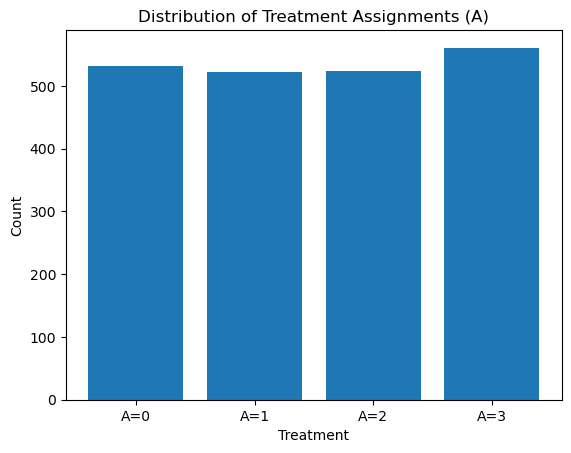

In [113]:
import numpy as np
import matplotlib.pyplot as plt
X, A, R, meta = actg_to_arrays(df, keep_R_pos=False, R_log=False, neg_scal=True)

# 치료 그룹 분포
unique, counts = np.unique(A, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Treatment {u}: {c} patients ({c/len(A):.2%})")

plt.bar(unique, counts, tick_label=[f"A={u}" for u in unique])
plt.title("Distribution of Treatment Assignments (A)")
plt.xlabel("Treatment")
plt.ylabel("Count")
plt.show()


R Summary Statistics
n=2139, mean=56.79, std=84.51, min=0.00, max=860.00


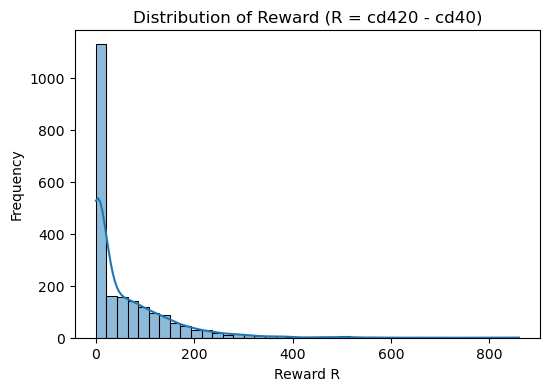

In [114]:
import seaborn as sns

print("R Summary Statistics")
print(f"n={len(R)}, mean={np.mean(R):.2f}, std={np.std(R):.2f}, "
      f"min={np.min(R):.2f}, max={np.max(R):.2f}")

# 히스토그램
plt.figure(figsize=(6,4))
sns.histplot(R, bins=40, kde=True)
plt.title("Distribution of Reward (R = cd420 - cd40)")
plt.xlabel("Reward R")
plt.ylabel("Frequency")
plt.show()


R Summary Statistics
n=1176, mean=102.15, std=91.69, min=1.00, max=860.00


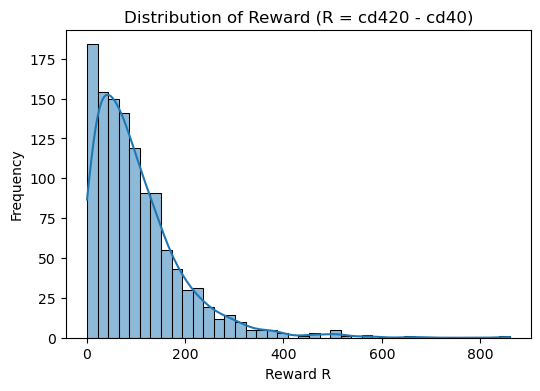

In [116]:
X, A, R, meta = actg_to_arrays(df, keep_R_pos=True, R_log=False, neg_scal=False)
import seaborn as sns

print("R Summary Statistics")
print(f"n={len(R)}, mean={np.mean(R):.2f}, std={np.std(R):.2f}, "
      f"min={np.min(R):.2f}, max={np.max(R):.2f}")

# 히스토그램
plt.figure(figsize=(6,4))
sns.histplot(R, bins=40, kde=True)
plt.title("Distribution of Reward (R = cd420 - cd40)")
plt.xlabel("Reward R")
plt.ylabel("Frequency")
plt.show()
